In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataset import ECGDataset, read_dataset_from_csv, dataset_folder, read_x_from_csv, read_x_from_mat
from sklearn.metrics import accuracy_score
from torchvision import transforms
from utils import smooth_predictions
from tqdm import tqdm

In [3]:
TRAIN = True
DATA_CSV = '70b_Day5_Data69_S2_src.csv'
DATA_PREFIX = DATA_CSV.split('.')[0]

NUM_OF_CLASS = 6
WAVEFORM_TYPE = 1
#0 = p-wave, 1 = pr-interval, 2 = qrs-comp, 3 = qt-interval, 4 = rr-interval

In [4]:
class ECGModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(ECGModel, self).__init__()
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        
        # Batch Normalization
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Classifier layer
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)
        
        # Sigmoid activation function for multi-label classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Reshape for batch normalization
        lstm_out_reshaped = lstm_out.contiguous().view(-1, lstm_out.shape[2])
        
        # Apply batch normalization
        norm_out = self.batch_norm(lstm_out_reshaped)
        
        # Apply activation function
        act_out = self.relu(norm_out)
        
        # Apply classifier to every time step
        time_steps = lstm_out.shape[1]
        out = self.classifier(act_out)
        
        # Apply sigmoid activation for multi-label classification
        out = self.sigmoid(out)
        
        # Reshape output back to (batch_size, time_steps, num_classes)
        return out.view(-1, time_steps, self.classifier.out_features)


In [4]:
#oldECGModel
""" class ECGModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(ECGModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Apply classifier to every time step
        time_steps = lstm_out.shape[1]
        out = self.classifier(lstm_out.reshape(-1, lstm_out.shape[2]))
        return out.view(-1, time_steps, self.classifier.out_features)
    
 """


' class ECGModel(nn.Module):\n    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):\n        super(ECGModel, self).__init__()\n        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)\n        self.classifier = nn.Linear(hidden_dim*2, num_classes)\n\n    def forward(self, x):\n        lstm_out, _ = self.lstm(x)\n        # Apply classifier to every time step\n        time_steps = lstm_out.shape[1]\n        out = self.classifier(lstm_out.reshape(-1, lstm_out.shape[2]))\n        return out.view(-1, time_steps, self.classifier.out_features)\n    \n '

In [12]:
if TRAIN:
    # Create Dataset and DataLoader 
    # Modify this based on your need 
    #dataset = read_dataset_from_csv(train_csv='data/train/s2_src.csv', label_csv='data/train/s2_lbl.csv')
    dataset = dataset_folder('./Test_ML')
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    print(f'Dataset len: {len(dataset)}')

    # Initialize the model
    model = ECGModel(input_dim=1, hidden_dim=128, num_layers=2, num_classes=NUM_OF_CLASS)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Training the model
    def train(model, dataloader, criterion, optimizer, num_epochs):
        model.train()
        for epoch in range(num_epochs):
            total_loss = 0
            for inputs, labels in dataloader:
                optimizer.zero_grad()
                outputs = model(inputs)
                outputs = outputs.view(-1, NUM_OF_CLASS)  # Shape should be (N*T, num_classes)
                labels = labels.view(-1, NUM_OF_CLASS)    # Shape should be (N*T, num_classes)
                loss = criterion(outputs, labels.float())
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(dataloader)}')
            torch.save(model.state_dict(), 'ecg_model.pth')

    # Example training call
    num_epochs = 50
    train(model, dataloader, criterion, optimizer, num_epochs)

Dataset len: 2273
Epoch 1, Average Loss: 0.8295804758171935
Epoch 2, Average Loss: 0.7403186188711153
Epoch 3, Average Loss: 0.7148283507440474
Epoch 4, Average Loss: 0.7054374247164159
Epoch 5, Average Loss: 0.7011957606235584
Epoch 6, Average Loss: 0.6986867647904617
Epoch 7, Average Loss: 0.6972039512821011
Epoch 8, Average Loss: 0.6963043817273387
Epoch 9, Average Loss: 0.6957433052829929
Epoch 10, Average Loss: 0.6951541462978283
Epoch 11, Average Loss: 0.6948334437150222
Epoch 12, Average Loss: 0.6945064630541768
Epoch 13, Average Loss: 0.6942867649185074
Epoch 14, Average Loss: 0.6940859718756243
Epoch 15, Average Loss: 0.693979799747467
Epoch 16, Average Loss: 0.6938950290213098
Epoch 17, Average Loss: 0.6937995869796593
Epoch 18, Average Loss: 0.6937066112364922
Epoch 19, Average Loss: 0.693622985086241
Epoch 20, Average Loss: 0.6935887741042184
Epoch 21, Average Loss: 0.693542494223668
Epoch 22, Average Loss: 0.6934929915241428
Epoch 23, Average Loss: 0.6934558199002192
Epoch

In [7]:
from tqdm import tqdm
#multi class classification code
""" model = ECGModel(input_dim=1, hidden_dim=64, num_layers=2, num_classes=NUM_OF_CLASS)
model.load_state_dict(torch.load('ecg_model.pth'))
print("Model loaded")
model.eval() 
#test_dataset = read_dataset_from_csv(train_csv='./Test_ML/70b_Day5_Data69_S2_src.csv', label_csv='./Test_ML/70b_Day5_Data69_S2_lbl.csv')
test_dataset = dataset_folder('./Train_ML')

# test_dataset = read_x_from_csv(f'./Test_ML/{DATA_CSV}')
# test_dataset = read_x_from_mat('data/exp_data/61b0.mat')
print("Dataset loaded")

test_dataloader = DataLoader(test_dataset, batch_size=16)
def test(model, dataloader):
    all_predictions = []
    all_labels = []
    all_srcs = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 2)  # Get predicted class for each time step
            all_predictions.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
            all_srcs.extend(inputs.cpu().numpy().flatten())

    return np.array(all_predictions), np.array(all_labels), np.array(all_srcs)

# Run the test
predictions, labels, srcs = test(model, test_dataloader)

labels_class_indices = np.argmax(labels, axis=0)

smoothed = smooth_predictions(predictions)
accuracy = accuracy_score(labels, predictions)
sm_acc = accuracy_score(labels, smoothed)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Accuracy smoothed: {sm_acc * 100:.2f}%') """

' model = ECGModel(input_dim=1, hidden_dim=64, num_layers=2, num_classes=NUM_OF_CLASS)\nmodel.load_state_dict(torch.load(\'ecg_model.pth\'))\nprint("Model loaded")\nmodel.eval() \n#test_dataset = read_dataset_from_csv(train_csv=\'./Test_ML/70b_Day5_Data69_S2_src.csv\', label_csv=\'./Test_ML/70b_Day5_Data69_S2_lbl.csv\')\ntest_dataset = dataset_folder(\'./Train_ML\')\n\n# test_dataset = read_x_from_csv(f\'./Test_ML/{DATA_CSV}\')\n# test_dataset = read_x_from_mat(\'data/exp_data/61b0.mat\')\nprint("Dataset loaded")\n\ntest_dataloader = DataLoader(test_dataset, batch_size=16)\ndef test(model, dataloader):\n    all_predictions = []\n    all_labels = []\n    all_srcs = []\n    with torch.no_grad():\n        for inputs, labels in tqdm(dataloader, desc="Testing"):\n            outputs = model(inputs)\n            _, predicted = torch.max(outputs.data, 2)  # Get predicted class for each time step\n            all_predictions.extend(predicted.cpu().numpy().flatten())\n            all_labels.ext

In [25]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# Load the model
model = ECGModel(input_dim=1, hidden_dim=128, num_layers=2, num_classes=NUM_OF_CLASS)
model.load_state_dict(torch.load('ecg_model.pth'))
print("Model loaded")
model.eval()

# Load the test dataset
test_dataset = dataset_folder('./Train_ML')
print("Dataset loaded")
test_dataloader = DataLoader(test_dataset, batch_size=16)

def test(model, dataloader, threshold=0.50003):
    all_predictions = []
    all_labels = []
    all_probabilities = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            outputs = model(inputs)
            # Apply sigmoid to get probabilities
            probabilities = torch.sigmoid(outputs)
            all_probabilities.extend(probabilities.cpu().numpy().flatten())
            # Binarize the probabilities using the threshold
            predicted = (probabilities > threshold).float()
            
            # Collect predictions and labels
            all_predictions.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    return all_predictions, all_labels, all_probabilities

# Run the test
predictions, labels, probabilities = test(model, test_dataloader)
smoothed = smooth_predictions(predictions)
# Compute the F1 score or other metrics for multi-label classification
# Accuracy score in multi-label classification is not typically used; consider F1 score or precision/recall
f1mic = f1_score(labels, predictions, average='micro')
f1mac = f1_score(labels, predictions, average='macro')
f1micsm = f1_score(labels, smoothed, average='micro')
f1macsm = f1_score(labels, smoothed, average='macro')
print(f'F1 Score Micro: {f1mic*100:.2f}')
print(f'F1 Score Macro: {f1mac*100:.2f}')
print(f'F1 Score Micro (smoothened): {f1micsm*100:.2f}')
print(f'F1 Score Macro (smoothened): {f1macsm*100:.2f}')


Model loaded
Dataset loaded


Testing: 100%|██████████| 222/222 [00:02<00:00, 76.80it/s]


F1 Score Micro: 85.42
F1 Score Macro: 61.02
F1 Score Micro (smoothened): 76.22
F1 Score Macro (smoothened): 54.72


Element: 0.0, Count: 61654
Element: 1.0, Count: 1003046
None


(array([7.08438e+05, 2.32756e+05, 5.33370e+04, 2.44300e+04, 1.61480e+04,
        9.67100e+03, 5.59200e+03, 3.45700e+03, 2.25600e+03, 1.59100e+03,
        1.28800e+03, 1.07100e+03, 8.10000e+02, 6.30000e+02, 5.22000e+02,
        4.31000e+02, 4.19000e+02, 3.45000e+02, 3.39000e+02, 2.66000e+02,
        2.44000e+02, 1.85000e+02, 1.68000e+02, 1.33000e+02, 7.40000e+01,
        4.90000e+01, 2.60000e+01, 1.10000e+01, 7.00000e+00, 6.00000e+00]),
 array([0.50000256, 0.50001496, 0.50002742, 0.50003982, 0.50005227,
        0.50006467, 0.50007713, 0.50008953, 0.50010198, 0.50011438,
        0.50012684, 0.50013924, 0.50015169, 0.50016409, 0.50017655,
        0.50018895, 0.50020134, 0.5002138 , 0.5002262 , 0.50023866,
        0.50025105, 0.50026351, 0.50027591, 0.50028837, 0.50030077,
        0.50031322, 0.50032562, 0.50033808, 0.50035048, 0.50036293,
        0.50037533]),
 <BarContainer object of 30 artists>)

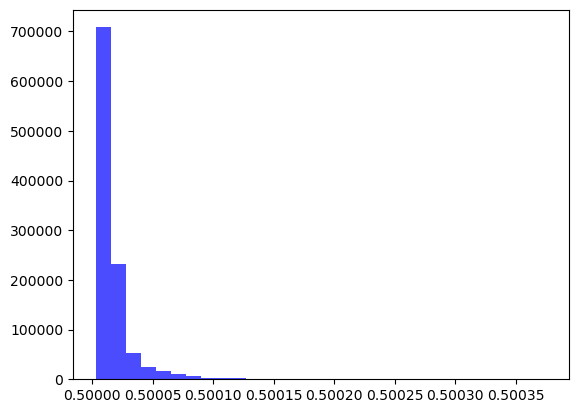

In [24]:
#test section
def count_unique_elements(arr):
    unique_elements, counts = np.unique(arr, return_counts=True)
    for elem, count in zip(unique_elements, counts):
        print(f'Element: {elem}, Count: {count}')


print(count_unique_elements(predictions))
plt.hist(probabilities, bins=30, alpha=0.7, color='blue') 

In [9]:



window_size = 128

# Extract the 300-sample window (for example, starting at index 100)
start_index = 200
end_index = start_index + window_size

# Extract the data for the window
src_window = srcs_og[start_index:end_index]
pw_window = pw[start_index:end_index]
pr_window = pr[start_index:end_index]
qrs_window = qrs[start_index:end_index]
qt_window = qt[start_index:end_index]
rr_window = rr[start_index:end_index]

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot src on the primary y-axis
ax1.plot(src_window, label='src', color='black', linestyle='--')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('src Value')
ax1.set_title('300 Sample Window of src with pw, pr, qrs, qt, and rr Overlaid')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylim(-6, 6)

# Plot the other vectors on the secondary y-axis
ax2.plot(pw_window, label='pw', color='blue')
ax2.plot(pr_window, label='pr', color='green')
ax2.plot(qrs_window, label='qrs', color='red')
ax2.plot(qt_window, label='qt', color='purple')
ax2.plot(rr_window, label='rr', color='orange')

# Add legends for both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

# Show plot
plt.show()


NameError: name 'srcs_og' is not defined

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 34438


In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
def to_roi_df(labels):
    changes = np.diff(labels, prepend=labels[0])

    # Identify the start and end indices
    starts = np.where(changes != 0)[0]
    ends = np.where(changes != 0)[0][1:]

    # Include the end of the last segment
    ends = np.append(ends, len(labels))

    # Get the wave types
    waves = labels[starts]

    # Create the DataFrame
    df = pd.DataFrame({
        'wave': waves,
        'start_index': starts,
        'end_index': ends - 1
    })

    # Filter out the segments with wave type 0
    df = df[df['wave'] != 0].reset_index(drop=True)

    # Map the wave types to their names
    wave_mapping = {1: 'P-Wave', 2: 'PR-Interval', 3: 'QRS-Complex', 4: 'QT-Interval', 5: 'RR-Interval'}
    df['wave'] = df['wave'].map(wave_mapping)
    df['duration'] = df['end_index'] - df['start_index']
    return df

def find_peaks_in_segment(segment, wave_type):
    plt.show()
    if wave_type == 'p':
        # For 'p' wave, we expect one peak
        peaks, _ = find_peaks(segment)
        if peaks.size == 0:
            return [np.nan]  # No peak found
        return [peaks[np.argmax(segment[peaks])]]  # Return the location of the highest peak
    elif wave_type == 'qrs':
        # For 'qrs' wave, we expect two peaks: R and J
        peaks, _ = find_peaks(segment)
        
        if peaks.size < 2:
            return [np.nan, np.nan]  # Less than 2 peaks found
        sorted_peaks = peaks[np.argsort(segment[peaks])][::-1]  # Sort peaks by height
        return sorted(sorted_peaks[:2])  # Return the two largest peaks in time order

# Function to get peaks from the DataFrame
def get_peaks_from_roi(df, signal):
    peaks_data = {'wave': [], 'peak1': [], 'peak2': [], 'duration':[]}
    
    for index, row in df.iterrows():
        segment = signal[row['start_index']:row['end_index'] + 1]

        peaks = find_peaks_in_segment(segment, row['wave'])
        print(peaks)
        peaks_data['wave'].append(row['wave'])
        peaks_data['peak1'].append(row['start_index'] + peaks[0] if not np.isnan(peaks[0]) else np.nan)
        print(row['start_index'] + peaks[0] if not np.isnan(peaks[0]) else np.nan)
        peaks_data['peak2'].append(row['start_index'] + peaks[1] if len(peaks) > 1 and not np.isnan(peaks[1]) else np.nan)
        peaks_data['duration'].append(row.duration)

    return pd.DataFrame(peaks_data)



def filter_peaks(df):
    valid_indices = []
    i = 0
    while i < len(df) - 1:
        if (df.iloc[i]['wave'] == 'p' and not np.isnan(df.iloc[i]['peak1']) and
            df.iloc[i + 1]['wave'] == 'qrs' and not np.isnan(df.iloc[i + 1]['peak1']) and not np.isnan(df.iloc[i + 1]['peak2'])):
            valid_indices.extend([i, i + 1])
            i += 2
        else:
            i += 1
    return df.iloc[valid_indices].reset_index(drop=True)

roi_df = to_roi_df(smoothed)

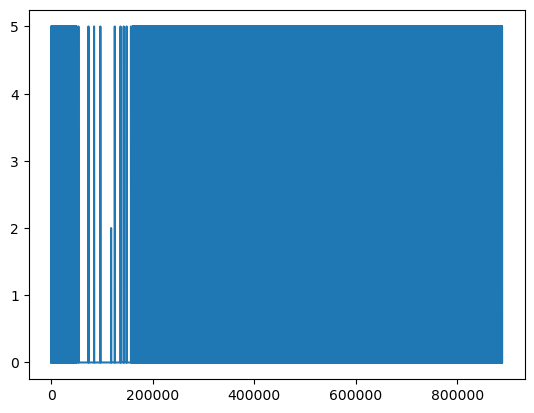

In [ ]:
peak_df = get_peaks_from_roi(roi_df, srcs)
peak_df = filter_peaks(peak_df)

None


TypeError: 'NoneType' object is not subscriptable

In [ ]:
len(signal)

In [ ]:
# peak_df.to_csv(f'{DATA_PREFIX}_peaks.csv')
peak_df

In [ ]:
def calculate_intervals(df, sampling_rate=512):
    intervals = {
        'p_peak_index': [],
        'pr_interval': [],
        'pj_interval': [],
        'duration':[]
    }
    
    i = 0
    while i < len(df) - 1:
        if (df.iloc[i]['wave'] == 'p' and not np.isnan(df.iloc[i]['peak1']) and
            df.iloc[i + 1]['wave'] == 'qrs' and not np.isnan(df.iloc[i + 1]['peak1']) and not np.isnan(df.iloc[i + 1]['peak2'])):
            p_peak_index = df.iloc[i]['peak1']
            qrs_peak1 = df.iloc[i + 1]['peak1']
            qrs_peak2 = df.iloc[i + 1]['peak2']
            
            pr_interval = (qrs_peak1 - p_peak_index) / sampling_rate
            pj_interval = (qrs_peak2 - p_peak_index) / sampling_rate
            print(f'({qrs_peak2} - {p_peak_index})/{sampling_rate} = {pj_interval}')
            print(pj_interval)
            
            intervals['p_peak_index'].append(p_peak_index)
            intervals['pr_interval'].append(pr_interval)
            intervals['pj_interval'].append(pj_interval)
            intervals['duration'].append(df.iloc[i].duration)
            
            i += 2
        else:
            i += 1
    
    return pd.DataFrame(intervals)

intervals = calculate_intervals(peak_df)
intervals['p_peak_index'] = intervals['p_peak_index'].astype(int)

In [ ]:

intervals.set_index('p_peak_index', inplace=True)
ecg_df = pd.DataFrame({"ECG":srcs, "Label":smoothed})
merged_df = ecg_df.merge(intervals, right_on='p_peak_index', left_index=True, how='left')
merged_df = merged_df.ffill().bfill()
merged_df.to_csv(f'data/intervals/{DATA_PREFIX}_intervals.csv')

In [ ]:
p_df = peak_df[peak_df['wave'] == 'p']
p_df['index'] = [int(x) for x in p_df['peak1']]
p_df['ppinterval'] = p_df['peak1'].diff()
p_df

In [ ]:
merged_df = merged_df.merge(p_df[['index', 'ppinterval']], right_on='index', left_index=True, how='left')
merged_df = merged_df.ffill().bfill()

In [ ]:
merged_df.to_csv(f"{DATA_PREFIX}_intervals.csv")